In [29]:
import cluster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use({'figure.figsize':(12, 12)}) # 画布大小
sns.set_style('whitegrid')  # 风格样式
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

data_path=cluster.data_path
info_path='./base_data/'
node_info = pd.read_csv(f'{data_path}node_words_feature.csv',encoding='utf_8_sig')
feats=node_info.iloc[:,2::].values
###
# info_path='./kmeans_interesting_node_info/' # interesting and node info
# node_info = pd.read_csv(f'{data_path}node_feats.csv',encoding='utf_8_sig')
###
from sklearn.preprocessing import StandardScaler
# feats=node_info.iloc[:,2::].values
scaler = StandardScaler()
scaler.fit(feats)
feats = scaler.transform(feats)

# [肘部法则选择K值](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)
# 如何在平滑曲线中识别拐点

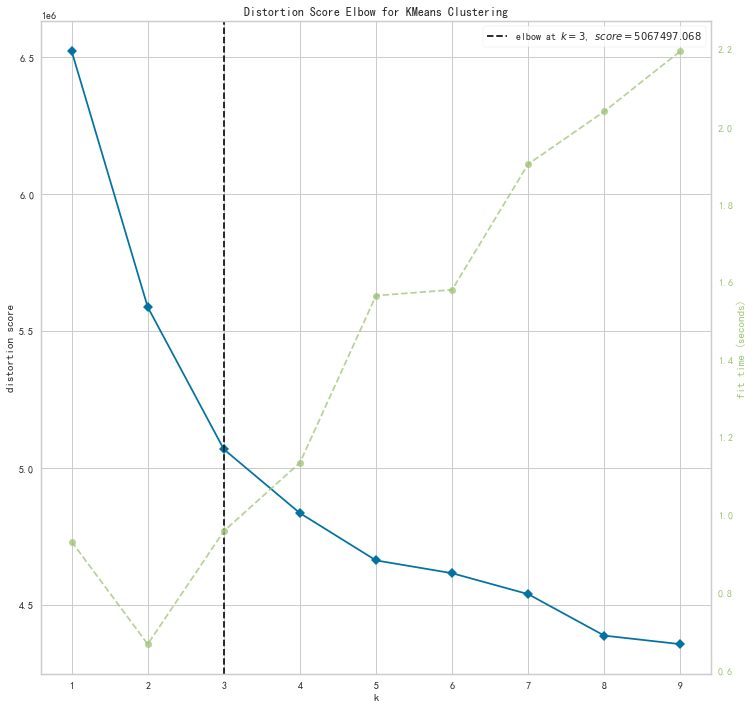

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(feats)        # Fit the data to the visualizer
# plt.title('手肘法则确定K值')
plt.savefig(f'{info_path}base_elbow_method.png')
visualizer.show()        # Finalize and render the figure

# 利用kmeans进行分类

In [31]:
kmeans=KMeans(n_clusters=visualizer.elbow_value_)   #n_clusters:number of cluster
kmeans.fit(feats)
print (kmeans.labels_)
node_info['cluster_result']=kmeans.labels_.T

[0 0 0 ... 0 0 0]


# pca降维 eda

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(feats)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
pos_new = pca.transform(feats)
pos_pca=pd.merge(left=pd.DataFrame(pos_new),right=node_info['cluster_result'],left_index=True,right_index=True,how='left')
print(pos_pca.describe())

[0.17943528 0.07143873]
[1081.83940934  682.61485714]
                  0             1  cluster_result
count  1.618500e+04  1.618500e+04    16185.000000
mean   2.826284e-16 -6.905059e-16        0.000927
std    8.503934e+00  5.365779e+00        0.042321
min   -7.459198e-01 -3.695940e+02        0.000000
25%   -7.305103e-01 -2.020211e-01        0.000000
50%   -5.380441e-01 -1.880915e-01        0.000000
75%   -9.400399e-02 -2.985243e-02        0.000000
max    8.919551e+02  4.401309e+02        2.000000


No handles with labels found to put in legend.


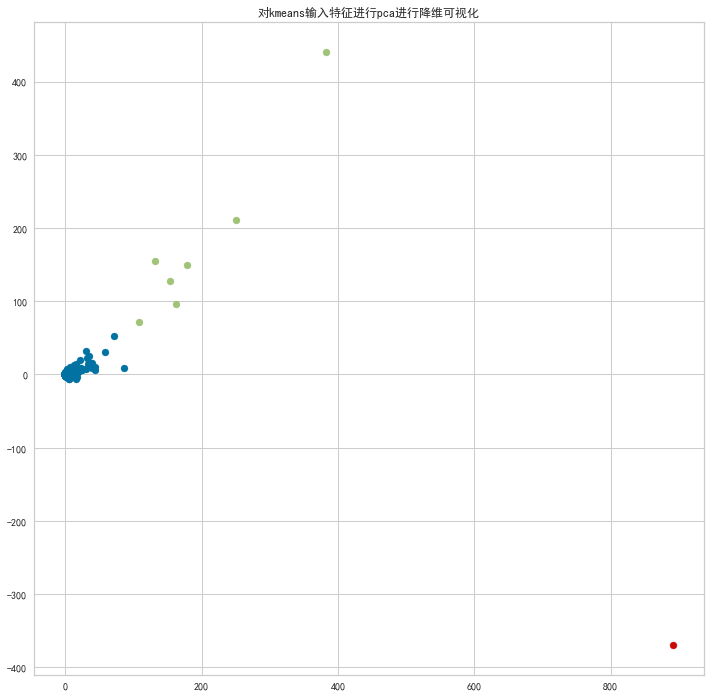

In [33]:
# plt.scatter(pos_pca.iloc[:,0],pos_pca.iloc[:,1],marker='o')
for i in pos_pca['cluster_result'].unique():
    plt.scatter(pos_pca[pos_pca['cluster_result']==i].iloc[:,0],pos_pca[pos_pca['cluster_result']==i].iloc[:,1],marker='o')
plt.title('对kmeans输入特征进行pca进行降维可视化')
plt.savefig(f'{info_path}pca_user.png')
plt.legend()
plt.show()

In [34]:
# sns.scatterplot(x=0,y=1,hue='cluster_result',data=pos_pca)
# plt.title('对kmeans输入特征进行pca进行降维可视化')
# plt.savefig(f'{info_path}pca_user.png')
# plt.legend()
# plt.show()

# t-sne eda
# 很耗时，大概one hour

In [35]:
# import numpy as np
# from sklearn.manifold import TSNE
# # 嵌入空间的维度为2，即将数据降维成2维
# ts = TSNE(n_components=2)
# # 训练模型
# ts.fit_transform(node_info[x_feature])
# # 打印结果
# print(ts.embedding_)
# position=pd.DataFrame(ts.embedding_)
# position=pd.merge(left=position,right=node_info['cluster_result'],left_index=True,right_index=True,how='left')
# sns.scatterplot(data=position,x=0,y=1,hue='cluster_result')
# plt.title('对kmeans输入特征进行t_sne进行降维可视化')
# plt.savefig(f'{info_path}t_sne_user.png')
# plt.show()

# 画出人群分部饼状图

ok
[0.9995057151683657, 6.178560395427866e-05, 0.00043249922767995056]


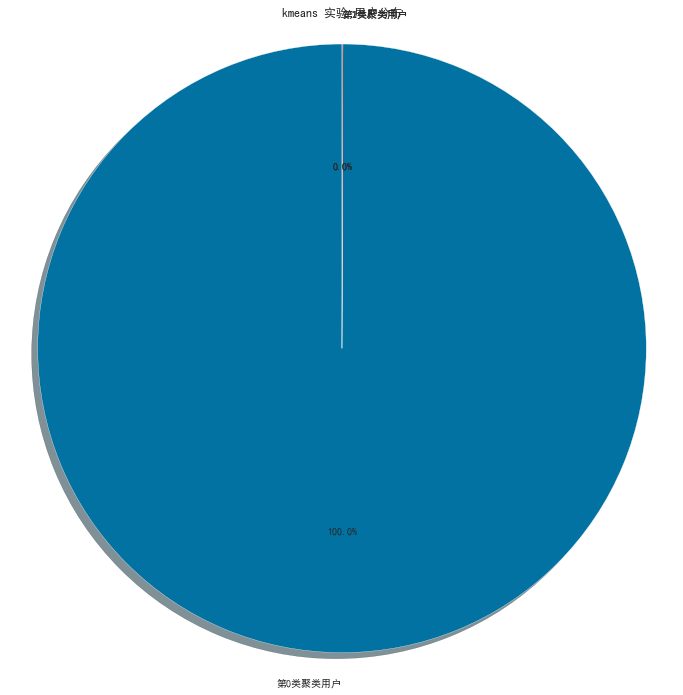

In [36]:
print('ok')
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =[f'第{i}类聚类用户' for i in range(visualizer.elbow_value_)]
total=node_info.shape[0]
sizes = [node_info[node_info['cluster_result']== i].shape[0]/total for i in range(visualizer.elbow_value_)]
print(sizes)
fig1, ax1 = plt.subplots()
explode = [0]* visualizer.elbow_value_  # only "explode" the 2nd slice (i.e. 'Hogs')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('kmeans 实验 用户分布')
plt.savefig(f'{info_path}user_cluster_pie.png')
plt.show()

# 可视化不同类人的关键词

In [37]:
data=[]
cols=node_info.columns[2:-1]
print(cols[-1])
for name,group in node_info.groupby('cluster_result'):
    tmp=[]
    tmp.append(name)
    for col in cols:
        tmp.append(group[col].sum())
    data.append(tmp)

_=['user_category']
_.extend(cols)
cols=_
result=pd.DataFrame(data,columns=cols)

显示


# 找出频率最高的前n个关键词

In [38]:
from tqdm import tqdm
n=10
data=[]
for index,row in tqdm(result.iterrows()):
    _row=row.tolist()
    tmp=[]
    _list=row.tolist()
    _list.sort(reverse= True)
    for i in range(n):
        tmp.append([index,result.columns[_row.index(_list[i])],_list[i]])
        _row[_row.index(_list[i])]=0
    data.extend(tmp)
    # break

3it [00:00, 3007.39it/s]


In [39]:
df=pd.DataFrame(data)

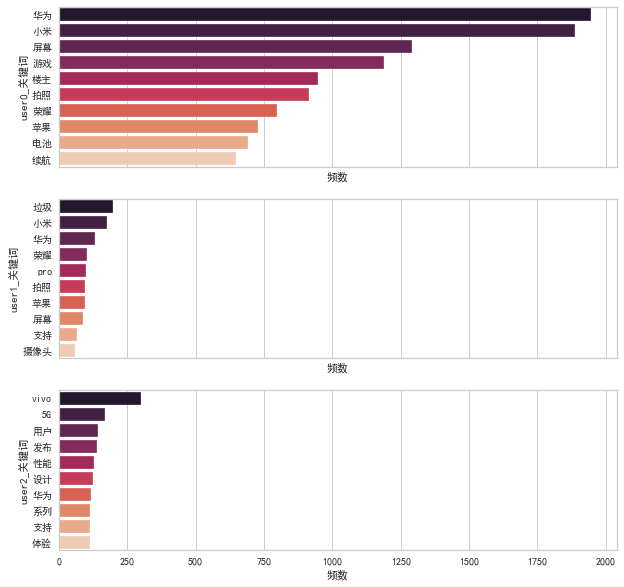

In [40]:
# sns.barplot( x=2,y=1, data=df,color="b",label='全部观点')
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
sns.barplot(x=2, y=1, data=df[df[0]==0],palette="rocket", ax=ax1)
ax1.set_ylabel("user0_关键词")
ax1.set_xlabel("频数")
sns.barplot(x=2, y=1, data=df[df[0]==1],palette="rocket", ax=ax2)
ax2.set_ylabel("user1_关键词")
ax2.set_xlabel("频数")
sns.barplot(x=2, y=1, data=df[df[0]==2],palette="rocket", ax=ax3)
ax3.set_ylabel("user2_关键词")
ax3.set_xlabel("频数")

plt.savefig(f'{info_path}user_words_compare.png')

In [41]:
t=[9,9]
print(t.index(9))

0


In [42]:
node_info[['author_user_name','cluster_result']].to_csv(f'{info_path}kmeans_result.csv',encoding='utf_8_sig',index=False)
result.to_csv(f'{info_path}user_words.csv',encoding='utf_8_sig',index=False)
# node_info[['id','cluster_result']].to_csv(f'{info_path}kmeans_result.csv',encoding='utf_8_sig',index=False)